In [2]:
import os
os.chdir("/workspaces/fire-detection/")

import h5py
import numpy as np
import matplotlib.pyplot as plt

from src.viirs_preprocess import preprocess

global mask_value 
mask_value = -1


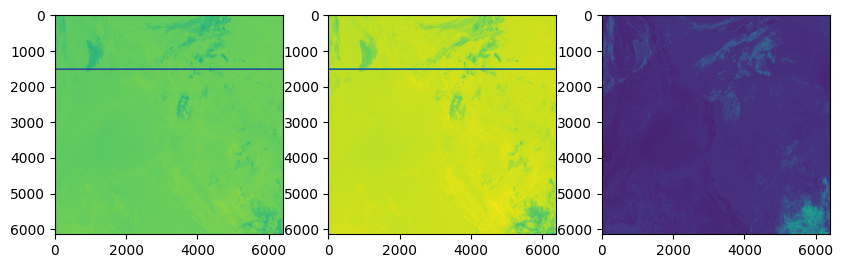

In [3]:

def read_I4_I5_data(I4_filename:str,I5_filename:str):
    '''
    notice that we want to mask bad quality data out
    '''
    error_flag = 65528 # value larger thatn this is stored for problematic data

    hdf_I4 = h5py.File(I4_filename,'r')
    bt_4s = hdf_I4['All_Data']['VIIRS-I4-SDR_All']['BrightnessTemperature'][:]
    bt_4s_sf = hdf_I4['All_Data']['VIIRS-I4-SDR_All']['BrightnessTemperatureFactors'][:2]
    I4_bt_arr = np.array(bt_4s*bt_4s_sf[0]+bt_4s_sf[1])
    I4_bt_arr[bt_4s>=error_flag] = mask_value

    hdf_I5 = h5py.File(I5_filename,'r')
    bt_5s = hdf_I5['All_Data']['VIIRS-I5-SDR_All']['BrightnessTemperature'][:]
    bt_5s_sf = hdf_I5['All_Data']['VIIRS-I5-SDR_All']['BrightnessTemperatureFactors'][:2]
    I5_bt_arr = np.array(bt_5s*bt_5s_sf[0]+bt_5s_sf[1])
    I5_bt_arr[bt_5s>=error_flag] = mask_value
    return (I4_bt_arr,I5_bt_arr)



test_file = "data/GIMGO-SVI04-SVI05_j01_d20220722_t1003522_e1009322_b24219_c20220818221532599234_oebc_ops.h5"
I4_bt_arr,I5_bt_arr = read_I4_I5_data(test_file,test_file)
I4_bt_arr = preprocess(I4_bt_arr)
I5_bt_arr = preprocess(I5_bt_arr)


fig,axes = plt.subplots(figsize=(10,15),ncols=3)
ax0,ax1,ax2 = axes.flat
ax0.imshow(I4_bt_arr)
ax1.imshow(I5_bt_arr)
ax2.imshow(I4_bt_arr-I5_bt_arr)
plt.show()

In [18]:
'''
we will perform a 4-step standard fire algorithm
based on one of my old paper: https://www.sciencedirect.com/science/article/pii/S0034425717302870
1. day/time confirming 
2. cloud 
3. candidate mask: spectral filter & spatial filter
4. contextual analysis
'''
from scipy import ndimage

def create_daynight_flag(I4_filename):
    '''
    to run a proper mask, we need zolar zenith angle to check
    however we can cheat here taking advantage no I1 data is collected during daytime
    so on AWS, we can just check the size of corresponded I1 file 
    smaller than 5MB, then we assume it is nighttime data
    '''

    return False

def get_cloud_mask(I4_arr,I5_arr,daynight_flag):
    cloud_mask = (I4_arr<265)&(I5_arr<295)
    return cloud_mask


def get_highpass_filter(input_arr:np.array)->np.array:  
    '''
    take input array (I4-I5) to produce a highpass filter
    '''  
    highpass_filter = np.zeros(input_arr.shape).astype(bool)   
    for ksize in np.arange(3,25,4):
        kernel=np.zeros(shape=(ksize,ksize))-1
        kernel[int(ksize/2),int(ksize/2)]=ksize**2-1
        mask=ndimage.convolve(input_arr, kernel)
        mask_k=(mask>=2.5*mask.std())
        highpass_filter=(highpass_filter|mask_k)
    return highpass_filter

def create_fire_candidate_mask(I4_bt_arr,I5_bt_arr,daynight_flag):
    if daynight_flag:
        thres_bt4 = 320
        thres_deltabt45 = 10
    else:
        thres_bt4 = 290
        thres_deltabt45 = 5
    # apprently median filter for such big size is a stupid idea, running ages, uniform_filter is much better
    med_filter_bt4 = ndimage.uniform_filter(I4_bt_arr,size=50)
    med_filter_bt4[med_filter_bt4<thres_bt4] = thres_bt4
    dif_I4_I5 = I4_bt_arr-I5_bt_arr
    med_filter_deltabt45 = ndimage.uniform_filter(dif_I4_I5,size=50)
    med_filter_deltabt45[med_filter_deltabt45<thres_deltabt45] = thres_deltabt45
    spectral_filter = ((I4_bt_arr>med_filter_bt4)&(dif_I4_I5>med_filter_deltabt45))

    highpass_filter = get_highpass_filter(I4_bt_arr-I5_bt_arr)
    fire_candidate_mask = highpass_filter&spectral_filter&(I4_bt_arr!=mask_value)
    return fire_candidate_mask

def contextural_analysis(I4_bt_arr,I5_bt_arr,cloud_mask,fire_candidate_mask,daynight_flag):
    nx_image,ny_image = I4_bt_arr.shape
    fxlist,fylist = np.where(fire_candidate_mask)
    window_size_min_max = (11,31)
    fire_list = []
    for fx,fy in zip(fxlist,fylist):
        for ws in np.arange(window_size_min_max[0],window_size_min_max[1],4):
            ix = max(0,fx-ws)
            jx = min(fx+ws+1,nx_image)
            iy = max(0,fy-ws)
            jy = min(fy+ws+1,ny_image)
            n_window = (jx-ix)*(jy-iy)
            n_invalid = ((cloud_mask[ix:jx,iy:jy])|(fire_candidate_mask[ix:jx,iy:jy])).sum()
            if n_invalid/n_window>0.75:
                # not enough valid pixel, continue extend window size
                continue
            I4_bt_pixel = I4_bt_arr[fx,fy]
            I5_bt_pixel = I5_bt_arr[fx,fy]
            dif_bt_pixel = I4_bt_pixel-I5_bt_pixel
            I4_bt_window = I4_bt_arr[ix:jx,iy:jy]
            I5_bt_window = I5_bt_arr[ix:jx,iy:jy]
            I4_bt_window_std = np.std(I4_bt_window)
            I5_bt_window_std = np.std(I5_bt_window)
            dif_bt_window_std = np.std(I4_bt_window-I5_bt_window)
            I4_bt_window_mean = np.mean(I4_bt_window)
            I5_bt_window_mean = np.mean(I5_bt_window)
            dif_bt_window_mean = np.mean(I4_bt_window-I5_bt_window)
            if daynight_flag:
                if I4_bt_pixel>I4_bt_window_mean+3.5*I4_bt_window_std:
                    if I5_bt_pixel>I5_bt_window_mean+I5_bt_window_std-4 or I4_bt_window_std>5:
                        if dif_bt_pixel>dif_bt_window_mean+2*dif_bt_window_std:
                            fire_list.append([fx,fy])
            else:
                if I4_bt_pixel>I4_bt_window_mean+3*I4_bt_window_std:
                    if dif_bt_pixel>dif_bt_window_mean+3*dif_bt_window_std:
                            fire_list.append([fx,fy])
    return fire_list

# 51s to run this! I am very happy with it
# think it was over 10min for 1/4 of the same imagery size for my phd implementation
daynight_flag = create_daynight_flag(test_file)
cloud_mask = get_cloud_mask(I4_bt_arr,I5_bt_arr,daynight_flag)
fire_candidate_mask = create_fire_candidate_mask(I4_bt_arr,I5_bt_arr,daynight_flag)
fire_list = contextural_analysis(I4_bt_arr,I5_bt_arr,cloud_mask,fire_candidate_mask,daynight_flag)

In [ ]:
def get_viirs_paired_geo_loc():
    return

def get_fire_loc(fire_list:np.array,viirs_geo_filename:str):
    return